# Reproducing Movie Tag classification model in PyTorch

This notebook is my "getting started" notebook for PyTorch, and I will work with our dataset on Movie Tag extraction. https://doi.org/10.1109/ACCESS.2019.2963535

## 1 Load the dataset

We can load datasets from folders with ImageFolder. Later, we can split the dataset in test, val, train with random_split.

### 1.1 Auxiliary functions for dataset

Let's define a function to load the dataset:                                          

In [3]:
import torch
from torchvision import datasets, transforms
import numpy as np

# what: loads the movie tag dataset from a folder, and a dictionary with the label names
# input: folder, image size, and verbosity
# return: data object
# example: data = load_movie_dataset('./data/Movie',[128,128])
def load_movietag_dataset(folder,im_size=[128,128],verbose=True):
    data = datasets.ImageFolder(
         folder,
         transform=transforms.Compose([transforms.ToTensor(),transforms.Resize(im_size)]),
         target_transform=transforms.Lambda(lambda y: torch.zeros(51, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
         )
    
    if verbose:
        print(f"Loaded {len(data)} samples")

    return data

/home/miguel/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now let's define a function to do the splits of the dataset:

In [4]:
# what: split the dataset in train test
# input: dataset object, the percentage for train, verbosity
# return: data objects for train an val
# example: train, val = data_splits(data,0.8)
def data_splits(dataset,tr_percent=0.8,verbose=True):
    total_size = len(data)
    train_size = int(np.floor(tr_percent*total_size))
    test_size  = total_size-train_size
    
    # we can split the dataset randomnly like this
    train, test = torch.utils.data.random_split(data, [train_size, test_size])
    
    if verbose:
        print(f"Splitted the dataset with {len(data)} samples. Train: {len(train)}, Test: {len(test)}")
    
    return train, test
    

One function to check the status of the dataset (randomnly show images)

In [5]:
import matplotlib.pyplot as plt

def print_random_samples(data):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item() # random number, get item because it's a random tensor
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(data.classes[torch.argmax(label).item()])
        plt.axis("off")
        plt.imshow(transforms.ToPILImage()(img)) #, cmap="rgb")
    plt.show()


The following function creates the data loaders (the iterators over the dataset).

In [6]:
from torch.utils.data import DataLoader

def create_data_loader(train,test,batch_size=32,cuda_avail=False):
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=cuda_avail)
    test_dataloader = DataLoader(test, batch_size=batch_size*2, num_workers=8, pin_memory=cuda_avail) 
    return train_dataloader, test_dataloader

### 1.2 Auxiliary functions for model

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model(model):
    print(model)
    print(f"Number of Parameters: {count_parameters(model)}")

## 2. Quick look to the dataset

We will load the dataset and print a couple of random samples

In [6]:
data = load_movietag_dataset('./data/Movie')

Loaded 34664 samples


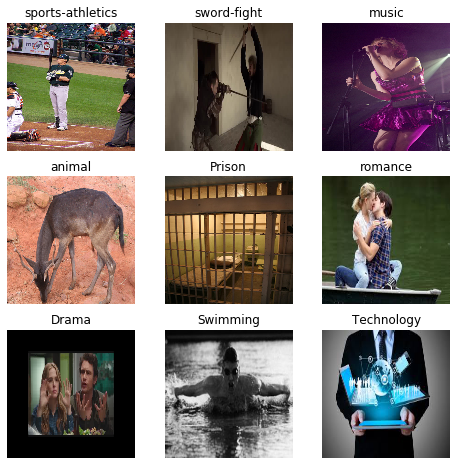

In [8]:
print_random_samples(data)

## 3. Model definition

Next, we define the model class

In [8]:
import torchvision.models as models
from torch import nn

class MovieInception(nn.Module):
    def __init__(self):
        super(MovieInception, self).__init__()      ## required!  
        self.inception = models.inception_v3(pretrained=True)        
        for param in self.inception.parameters(): # feature extractor
            param.requires_grad = False
        self.inception.AuxLogits.fc = nn.Linear(768, 51)
        self.inception.fc = nn.Linear(in_features=2048, out_features=51, bias=True) # replace by a new linear layer
        self.inception.AuxLogits.fc.requires_grad = True   # not required!
        self.inception.fc.requires_grad = True
        self.inputSize = [299,299] # according to https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
        
    def forward(self, x):
        x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x)
        return self.inception(x)
    
    def getInputSize(self):
        return self.inputSize
    
    def getTrainParameters(self):
        return filter(lambda p: p.requires_grad, self.inception.parameters())
        #[next(self.inception.fc.parameters()),next(self.inception.AuxLogits.parameters())]
    
    


In [23]:
model = MovieInception()

## 4. Training the model

### 4.1. Check CUDA installation

Let's check if we have CUDA on the server

In [10]:
cuda_enabled = torch.cuda.is_available()

device = "cuda" if cuda_enabled else "cpu"
print(f"Using {device} device")

torch.cuda.get_device_name(torch.cuda.current_device())

Using cuda device


'NVIDIA GeForce RTX 2080'

### 4.2. Load the dataset and create data loaders
Load the dataset and split in test and train

In [24]:
image_res=model.getInputSize()  # input resolution to the model

# load the dataset
data = load_movietag_dataset('./data/Movie',image_res)

# split the data
train, test = data_splits(data,0.8)

Loaded 34664 samples
Splitted the dataset with 34664 samples. Train: 27731, Test: 6933


Show random samples

Create the data loaders for train and test

In [25]:
train_loader, test_loader = create_data_loader(train,test,batch_size=32,cuda_avail=cuda_enabled)

# For debugging purposes, I will get the first samples
train_features, train_labels = next(iter(train_loader))

In [24]:
#model(train_features)

InceptionOutputs(logits=tensor([[ 0.4026,  0.3404,  0.3930,  ...,  0.9046,  0.4285, -0.4088],
        [ 0.3967, -0.0772,  0.1193,  ..., -0.3373,  0.1033, -0.2137],
        [ 0.4499,  0.0314, -0.0793,  ..., -0.4783, -0.0041, -0.4318],
        ...,
        [ 0.1476,  0.3089,  0.4321,  ..., -0.3958,  0.4338, -0.1936],
        [ 0.0275, -0.1115,  0.2396,  ..., -0.0674,  0.7595,  0.3578],
        [ 0.2642, -0.1357,  0.0786,  ..., -0.0930, -0.1538, -0.3826]],
       grad_fn=<AddmmBackward0>), aux_logits=tensor([[-0.0595,  1.0087,  0.3901,  ...,  0.1523, -1.0335, -0.0089],
        [-0.7416,  0.7578,  0.5265,  ...,  0.1281, -0.5430, -0.3168],
        [-0.4271,  0.0191,  0.5888,  ...,  0.3395, -0.1874,  0.6504],
        ...,
        [-0.5690,  0.4707,  0.7746,  ...,  0.0429, -0.4278, -0.5405],
        [-0.5186,  0.6056,  0.3724,  ..., -0.1049, -0.6075,  0.2363],
        [-0.9261,  0.2687,  0.2995,  ...,  0.5940, -0.8971, -0.1398]],
       grad_fn=<AddmmBackward0>))

### 4.3 Create the model

In [15]:
#Test the model. This is good to know the output shape of the network
#model = MovieInception()

In [26]:
#model = MovieInception()
# send the model to the GPU
if cuda_enabled:
    model = model.cuda()

In [14]:
print_model(model)

MovieInception(
  (inception): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3)

### 4.4. Optimizer and loss function


In [27]:
from torch.optim import Adam, SGD

learning_rate = 0.001

# defining the optimizer (receives the parameters of the model!)
optimizer = Adam(model.getTrainParameters(), lr=learning_rate)

# defining the loss function, in this caase cross entropy loss (it has softmax embedded!)
loss_func = nn.CrossEntropyLoss()

In [28]:
# send the loss to the GPU
if torch.cuda.is_available():
    loss_func = loss_func.cuda()

In [29]:
def accuracy(pred,y):
    return (pred.argmax(1)==y.argmax(1)).float().mean().item()

In [30]:
def validation(model,dataloader):
    model.eval()
    loss = accu = 0
    for X, Y in dataloader: 
        X=X.cuda()
        Y=Y.cuda()
        
        with torch.no_grad():
            pred = model(X)
        
            loss += loss_func(pred, Y) * len(X)
            accu += accuracy(pred,Y) * len(X)
    model.train()
    return loss.item()/len(dataloader.dataset), accu/len(dataloader.dataset)

### 4.5 Train loop

In [18]:
import torch
from torch.utils.tensorboard import SummaryWriter


In [31]:
import time

def train(model, traindl, valdl, epochs=20, tensorboard=False, printstep=100):

    # number of samples in training, TODO what if data augmentation?
    size = len(traindl.dataset) 

    print (f"number of samples {size}")
    print (f"number of epochs {epochs}")

    tb_writer = None
    if tensorboard:           # create the log dir
        tb_writer = SummaryWriter()
        
    for epoch in range(epochs):
        t0 = t1 = time.time()     # our timers
        print(f"epoch: {epoch}")
        loss_train = acc_train = 0
        
        for batch, (X, Y) in enumerate(traindl):  # for each sample
            # send the data to the GPU
            X=X.cuda()
            Y=Y.cuda()

            # FORWARD            
            pred, aux_pred = model(X)           # Compute prediction of the network            
            loss1 = loss_func(pred, Y) # Calculate the loss
            aux_loss = loss_func(aux_pred, Y) # Calculate the loss from aux exit
            loss = loss1 + 0.44*aux_loss

            # BACKWARD        
            loss.backward()        # the backpropagation phase, from loss to all recorded tensors        
            optimizer.step()       # one step of the optimizer        
            optimizer.zero_grad(set_to_none=True)  # gradients are accumulated in PyTorch, need to zero them.        
            #for param in model.parameters():  # this loop is similar to using set_to_none=True in zero_grad
            #    param.grad = None
            
            loss, current = loss.item(), batch * len(X) # calculate loss and acc
            acc = accuracy(pred,Y)

            if tensorboard:  # write to tensorboard
                tb_writer.add_scalar("Loss/train", loss, current+epoch*size)
                tb_writer.add_scalar("Accuracy/train", acc, current+epoch*size)

            if (printstep > 0 and batch > 0 and batch % printstep == 0):                    
                print(f"loss: {loss:>7f} accuracy: {acc:>7f}  [{current:>5d}/{size:>5d}/{epoch:>2d}] | elapsed time: {time.time() - t1:>4f} s")
                t1 = time.time()  # timer for batches
            
            loss_train += loss*len(X) # remove the mean
            acc_train += acc*len(X)   # remove the mean


        loss_train = loss_train / size  # mean of loss and acc for train
        acc_train  = acc_train / size
        print(f"Train: loss: {loss_train:>7f} accuracy: {acc_train:>7f} | elapsed time: {time.time() - t0:>4f} s")          
        t0 = time.time()
        
        loss, acc = validation(model,valdl)  # validation phase
        print(f"Validation: loss: {loss:>7f} accuracy: {acc:>7f} | elapsed time: {time.time() - t0:>4f} s")  

        if tensorboard:   # write validation to tensorboard
            tb_writer.add_scalar("Loss/val", loss, epoch)
            tb_writer.add_scalar("Accuracy/val", acc, epoch)
    
    if tensorboard:
        tb_writer.flush()
        tb_writer.close()

In [32]:
train(model,train_loader,test_loader,epochs=20,printstep=200,tensorboard=True)

number of samples 27731
number of epochs 20
epoch: 0
loss: 2.331227 accuracy: 0.625000  [ 6400/27731/ 0] | elapsed time: 14.536927 s
loss: 1.252114 accuracy: 0.750000  [12800/27731/ 0] | elapsed time: 14.117404 s
loss: 1.627779 accuracy: 0.531250  [19200/27731/ 0] | elapsed time: 14.151897 s
loss: 1.243811 accuracy: 0.781250  [25600/27731/ 0] | elapsed time: 14.183460 s
Train: loss: 1.878046 accuracy: 0.660813 | elapsed time: 61.665575 s
Validation: loss: 0.868501 accuracy: 0.755806 | elapsed time: 15.113275 s
epoch: 1
loss: 1.410065 accuracy: 0.687500  [ 6400/27731/ 1] | elapsed time: 14.722276 s
loss: 1.467201 accuracy: 0.718750  [12800/27731/ 1] | elapsed time: 14.374999 s
loss: 1.314305 accuracy: 0.750000  [19200/27731/ 1] | elapsed time: 14.421811 s
loss: 1.225021 accuracy: 0.718750  [25600/27731/ 1] | elapsed time: 14.521830 s
Train: loss: 1.232032 accuracy: 0.743320 | elapsed time: 62.817091 s
Validation: loss: 0.745572 accuracy: 0.785519 | elapsed time: 15.380229 s
epoch: 2
los